In [ ]:
import os.path
import scipy.io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pywt
import pywt.data
from scipy import signal

import seaborn as sns
%matplotlib inline

In [202]:
# Load in provided raw waveform data

mat = scipy.io.loadmat('tetrode12.mat')
RawData = mat['spikes_ep2']

In [ ]:
from scipy import signal

FS = 30000

# Pass signal through a bandpass filter
b, a = signal.butter(4, [600/(FS/2), 6000/(FS/2)], btype='bandpass')

FilteredData = signal.lfilter(b, a, RawData, axis=0)

In [ ]:
def data_preprocessing(FilteredData):
  '''
  Computes the indices where FilteredData exceeds 60.
  This is a naive approach to thresholding; more robust approaches would
    enforce a 1ms interspike interval. 
  '''
  SnippetLength = 40
  SnippetPre = 10
  SnippetPost = SnippetLength - SnippetPre
  Threshold = 60

  DataLen = FilteredData.shape[0] - (SnippetPost)

  # can be remanipulated 
  # it is not robust spike detection but it's ok
  OverThreshold = np.where(FilteredData > Threshold)
  central = list(np.where(FilteredData > Threshold)[0])
  all_indices = []
  for i in central:
    for j in range(i-SnippetPre, i+SnippetPost+1):
      all_indices.append(j) 
  return all_indices 

In [ ]:
# Wavelet Implementation

def add_gaussian_noise(real_signal, spikes, amp):
  '''
  Adds white (Gaussian) noise to original signal.
  Inputs:
    real_signal: original spike waveform
    spikes: concatenation of all action potential values throughout real_signal
    amp: amplitude of Gaussian noise to add
  Outputs:
    snr: SNR (signal-to-noise ratio) of artificial_signal
    artifical_signal: new waveform with Gaussian noise added to original waveform
  '''
  # Create new signal with added Gaussian noise
  noise = amp * np.random.normal(0, 1, len(real_signal))
  artificial_signal = real_signal + noise

  # Calculate new SNR (Equation 11 from paper)
  snr = 10 * np.log10(((len(real_signal) / len(spikes)) * (np.sum(spikes ** 2))) / np.sum(artificial_signal ** 2))

  # Normalize new signal 
  artificial_signal = artificial_signal / np.sum(artificial_signal)
  
  return snr, artificial_signal


In [ ]:
def detect_aps_offline(signal): # implement equations 5 and 6
  median = np.median(signal)
  sd = median / 0.6795
  threshold = sd * np.sqrt(2 + np.log(len(signal)))
  return np.nonzero(signal >= threshold)[0] # array of detected AP indices

In [ ]:
def swt(signal):
  '''
  Implement SWT (Figure 3) for detail levels 1-4 using Haar as mother wavelet
  '''
  haar = pywt.Wavelet('haar')
  detail_coeffs = []
  coeffs = pywt.swt(signal, haar, level=4)
  detail_coeffs.append(np.array([c[1] for c in coeffs]))
  return np.vstack(detail_coeffs)

In [ ]:
def evaluate_accuracy(preds, truth):
  '''
  Evaluates the detection accuracy (true positive rate) of preds relative to
    truth; returns percent of true positives detected.
  '''
  total_pos = len(truth)
  return (len(np.intersect1d(preds, truth)) / total_pos) * 100

In [ ]:
def detect_aps_online(sig, waveform, level): 
  '''
  Uses wavelet analysis to detect action potentials in sig.
  Inputs:
    waveform: original spike waveform
    sig: signal (containing additive Gaussian noise) from which to detect APs
    level: SWT detail level to use for detection
  Outputs:
    indices of detected APs within sig
  '''
  # Implement online detection (Figure 4)
  wavelet_result = swt(sig)
  dk = np.abs(wavelet_result[-1*level, :])
  dk1 = np.abs(wavelet_result[-1, :])
  P = 0.318
  G1 = 40
  sd = np.median(waveform) / 0.6795
  f1 = signal.zpk2sos([1], [-0.9937], 0.00311279) 
  f11, f12 = signal.butter(4, 10, fs = 10000)

  # Approximate SD (standard deviation)
  for _ in range(100): 
    after_a = dk1 > sd
    after_f1 = signal.lfilter(f11, f12, after_a, axis=0)
    sd = (G1 * (after_f1) - P)
    
  f2 = signal.zpk2sos([1], [-0.9937], 0.00311279) 
  f21, f22 = signal.butter(4, 10, fs = 10000)
  G2 = 2.75/1000
  after_f2 = signal.lfilter(f21, f22, sd, axis=0)
  threshold = np.abs(G2 * after_f2)
  detected = np.nonzero(dk > np.mean(threshold))
  return detected[0]

In [ ]:
amplitudes = np.arange(2, 48, 4) # Gives SNR range 0 to 10dB

# Concatenate all ground-truth spikes
waveform = np.transpose(FilteredData)[0][0:50000]
spike_times = np.unique(data_preprocessing(waveform))

spikes = waveform[spike_times]
last_snr = 10
snr = 11

all_snrs = []
all_accs = []

all_preds = []
all_truth = []
# Iterate through SNRs 0-10 dB
for amp in amplitudes:
  snrs = []
  detection_accs = []
  while snr >= last_snr:
    snr, sig = add_gaussian_noise(waveform, spikes, amp)
    if snr < 0:
      break
  last_snr = snr
  if snr < 0:
    break

  # Iterate through detail levels 1-4
  for level in range(1, 5):
    # Use wavelet detection
    detected_aps = detect_aps_online(sig, waveform, level)
    # Compute detection accuracy
    all_preds.append(detected_aps)
    all_truth.append(spike_times)
    acc = evaluate_accuracy(detected_aps, spike_times)
    
    snrs.append(snr)
    detection_accs.append(acc)

  all_snrs.append(snrs)
  all_accs.append(detection_accs)

snr_x = np.transpose(np.vstack(all_snrs))
acc_y = np.transpose(np.vstack(all_accs))

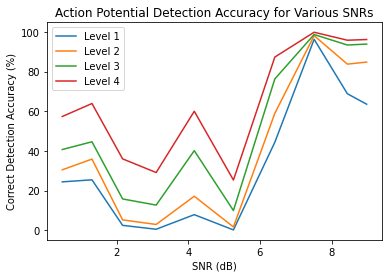

In [ ]:
plt.plot(snr_x[0], acc_y[0], label = "Level 1")
plt.plot(snr_x[1], acc_y[1], label = "Level 2")
plt.plot(snr_x[2], acc_y[2], label = "Level 3")
plt.plot(snr_x[3], acc_y[3], label = "Level 4")
plt.xlabel("SNR (dB)")
plt.ylabel("Correct Detection Accuracy (%)")
plt.legend()
plt.title("Action Potential Detection Accuracy for Various SNRs")
plt.show()

Below is the attempt to denoise the signal with FFT before I recalled scipy.signal has built-in filters lol :)

In [ ]:
# Denoising

from scipy.fft import fft, fftfreq

# get the list of frequencies
num=np.size(x)
freq = [i / num for i in list(range(num))]

# get the list of spectrums
spectrum=f.real*f.real+f.imag*f.imag
nspectrum=spectrum/spectrum[0]

# plot nspectrum per frequency, with a semilog scale on nspectrum
plt.semilogy(freq,nspectrum)

In [ ]:
dt = 1
n = waveform.shape[0]
F = fft(waveform)
w = fftfreq(n, dt)
t=np.linspace(1, n, n)
T = n/t[0:n]
indices = np.where(w > 0)
w_pos = abs(w[indices])
F_pos = abs(F[indices])

In [ ]:
print(np.shape(t))
print(np.shape(waveform))
print(n)
print(np.shape(F))
print(np.shape(abs(F[indices])))

print(w)

In [ ]:
fig1 = plt.figure()
ax = fig1.add_axes([0, 0, 2, 0.8])
axF = fig1.add_axes([0, 1.2, 2, 0.8])
axF.plot(w_pos, abs(F_pos))
axF.set_xlabel('Frequency', fontsize = 13)
axF.set_ylabel('magnitude', fontsize = 13)
axF.set_title('Periodogram (FFT Result)', fontsize = 15)
axF.tick_params(labelsize = 13)
ax.plot(T, abs(F_pos))
ax.set_xlabel('Period', fontsize = 13)
ax.set_ylabel('magnitude', fontsize = 13)
ax.set_title('Periodogram (FFT Result)', fontsize = 15)
ax.tick_params(labelsize = 13)

In [ ]:
from numpy.fft import fft, ifft

sr = 2000
x = waveform
X = fft(x)
N = len(X)
n = np.arange(N)
T = len(waveform)/30000
freq = n/T 

plt.figure(figsize = (12, 6))
plt.subplot(121)

plt.stem(freq, np.abs(X), 'b', \
         markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.xlim(0, 10)

plt.subplot(122)
plt.plot(t, ifft(X), 'r')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

In [ ]:
EEG = waveform

x = EEG                               # Relabel the data variable
dt = len(waveform)/30000                  # Define the sampling interval
N = x.shape[0]                        # Define the total number of data points
T = N * dt                            # Define the total duration of the data

xf = fft(x - x.mean())                # Compute Fourier transform of x
Sxx = 2 * dt ** 2 / T * (xf * xf.conj())  # Compute spectrum
Sxx = Sxx[:int(len(x) / 2)]           # Ignore negative frequencies

df = 1 / T.max()                      # Determine frequency resolution
fNQ = 1 / dt / 2                      # Determine Nyquist frequency
faxis = np.arange(0,fNQ,df)              # Construct frequency axis

plt.plot(faxis, Sxx.real)                 # Plot spectrum vs frequency
plt.xlim([0, 100])                        # Select frequency range
plt.xlabel('Frequency [Hz]')              # Label the axes
plt.ylabel('Power [$\mu V^2$/Hz]')
plt.show()